# Growth media for the AGORA database

AGORA is a database targeting the gut microbiota. As such we already supplied a growth medium based on an average western diet. We will start from this medium to illustrate how we can inspect the performance of growth medium in a model database and how to supplement a medium to allow fro growth for all models.

The growth medium supllied here was created the following way:

1. start with the growty medium reported in https://doi.org/10.1038/nbt.4212
2. manually dilute all components absorbed in the small intestine (simple sugars, vitamins, amino acids, etc) 1:10 
3. add in mucin
4. deplete oxygen since the lower gut is mostly anaerobic

We can take a look by reading it using micom.

In [19]:
import pandas as pd

medium = pd.read_csv("data/agora103_western_gut.csv", index_col=False)
medium

,flux,dilution,metabolite,reaction,global_id
0,0.014899,0.100,fru_m,EX_fru_m,EX_fru(e)
1,0.014899,0.100,glc_m,EX_glc_m,EX_glc(e)
2,0.014899,0.100,gal_m,EX_gal_m,EX_gal(e)
3,0.014899,0.100,man_m,EX_man_m,EX_man(e)
4,0.014899,0.100,mnl_m,EX_mnl_m,EX_mnl(e)
...,...,...,...,...,...
165,0.100000,0.100,glu_D_m,EX_glu_D_m,EX_glu_D(e)
166,0.100000,0.100,gthrd_m,EX_gthrd_m,EX_gthrd(e)
167,0.100000,0.100,h2_m,EX_h2_m,EX_h2(e)
168,0.100000,0.100,no2_m,EX_no2_m,EX_no2(e)


The fluxes here are the already diluted amounts and denote the upper bound for the import (can be less). The dilution factors are kept here for the sake of reproducibility. 

## Checking the growth medium against the DB

But can the bacteria in our model database actually grow on this medium? Let's check and start by downbloading the AGORA model database.

In [17]:
# !wget https://zenodo.org/record/3755182/files/agora103_genus.qza?download=1 -O data/agora103_genus.qza

No we we will check for growth by running the growth medium against any single model.

In [20]:
from micom.workflows.db_media import check_db_medium

check = check_db_medium("data/agora103_genus.qza", medium, threads=20)

`check` now includes the entire manifest plus two new columns: the growth rate and whether the models can grow.

In [21]:
check.can_grow.value_counts()

True    227
Name: can_grow, dtype: int64

No that bad. more than half of all the genera can grow.

(array([ 2.,  3.,  5.,  7., 13., 27., 77., 30., 21., 42.]),
 array([-3.40288095, -3.0992051 , -2.79552925, -2.4918534 , -2.18817754,
        -1.88450169, -1.58082584, -1.27714999, -0.97347414, -0.66979829,
        -0.36612243]),
 <a list of 10 Patch objects>)

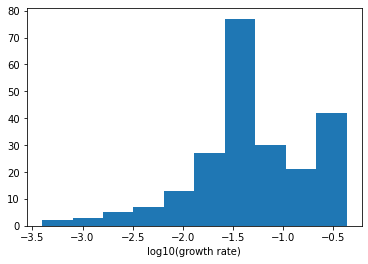

In [22]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np

plt.xlabel("log10(growth rate)")
plt.hist(np.log10(check.growth_rate[check.can_grow])) 

We see the the smallest growth rate that can be reached is around 10^-5. Let's complete the medium so that all taxa in Refseq can grow at a rate of at least 10^-3.

## Supplementing a growth medium from a skeleton

Sometimes you may start from a few componenents and will want to complete this skeleton medium to reach a certain minimum growth rate across all models in the database. This can be done with `complete_db_medium`.

In [23]:
from micom.workflows.db_media import complete_db_medium

manifest, imports = complete_db_medium("data/agora103_genus.qza", medium, growth=0.001, threads=20)

`manifest` is the amended manifest as before and `imports` contains the used import fluxes for each model. A new column in the mnaifest also tells us how many import were added.

In [24]:
manifest.added.describe()

count    226.000000
mean       0.022124
std        0.239345
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: added, dtype: float64

So we added at max 3 metabolites to the imports and in most cases none (as the previous medium was already good). We can also have a look at the used imports across all models.

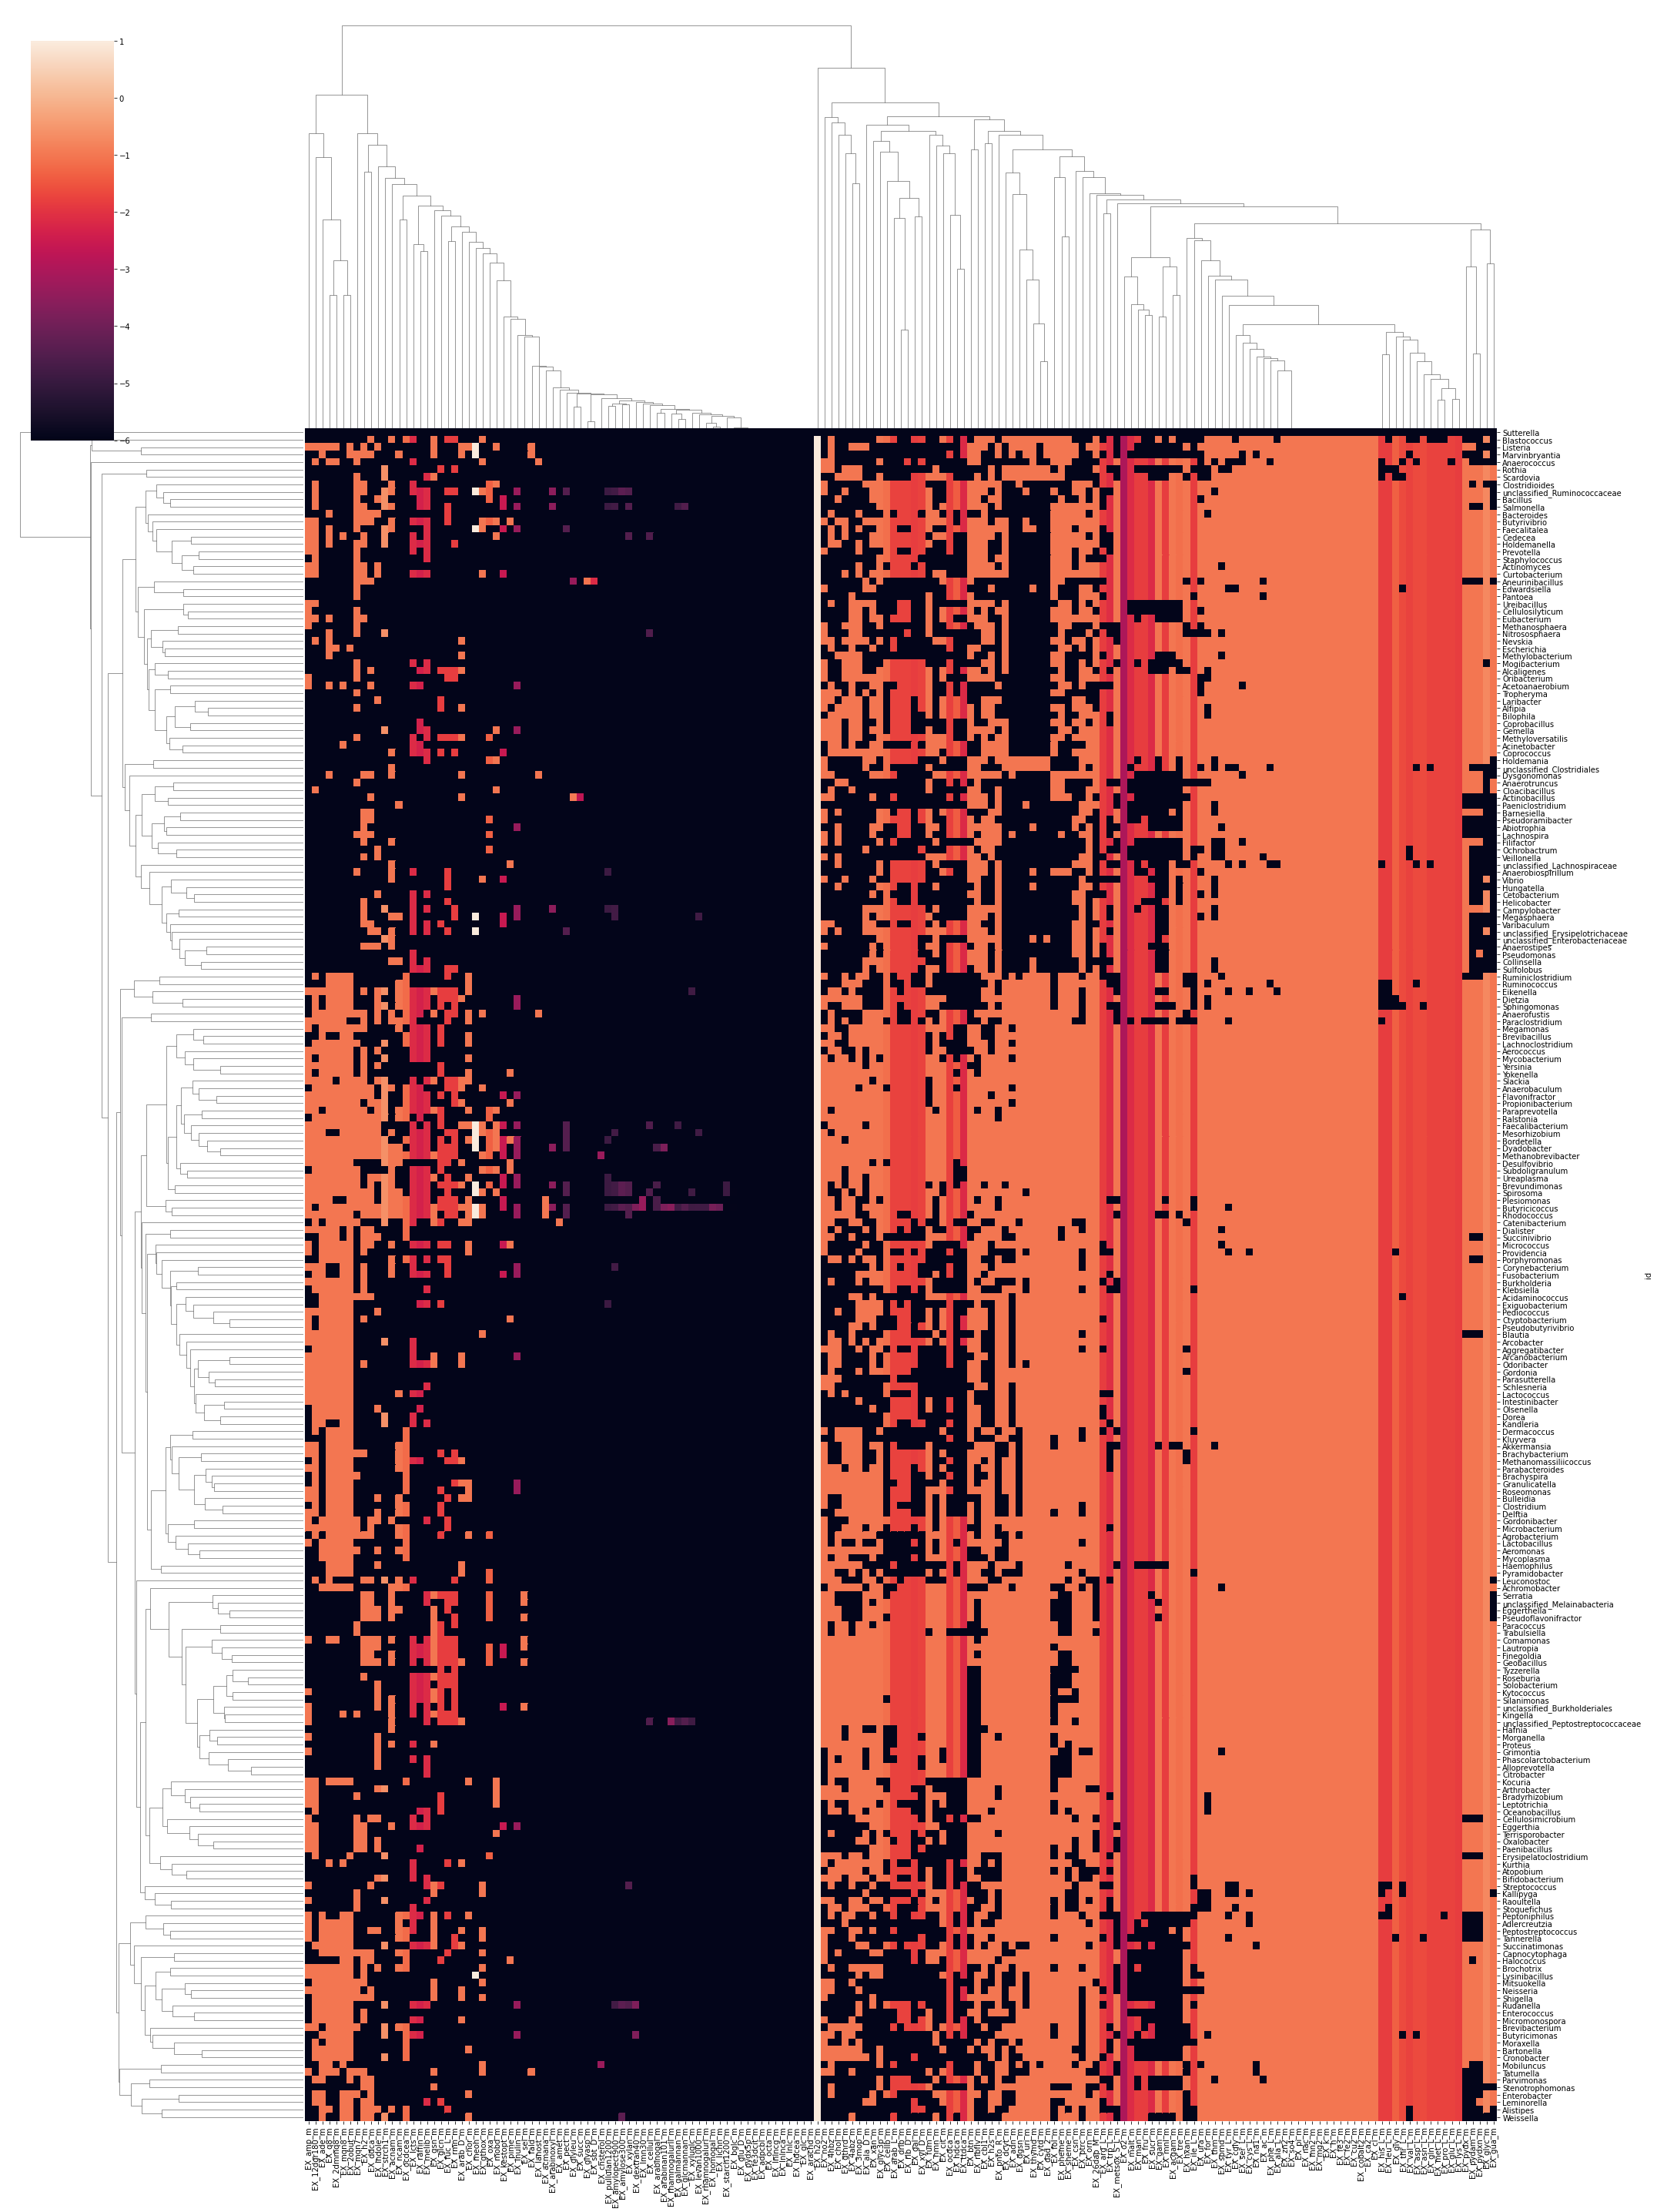

In [25]:
import seaborn as sns

sns.clustermap(np.log10(imports + 1e-6), xticklabels=True, yticklabels=True, figsize=(30, 40))

As we can see some metabolites are consumed by all taxa but there are also many taxa-specific ones. If you know you will only use a subset of the database you can use the `imports` matrix to design a new more minimal growth medium. For instance let's build a medium for only taxa from the Bacteroidetes phylum.

In [26]:
bacteroidetes = manifest[manifest.phylum == "Bacteroidetes"].id
bac_medium = imports.loc[bacteroidetes].max()
bac_medium = bac_medium[bac_medium > 0]
bac_medium

EX_ac_m             1.000000e-01
EX_ala_L_m          1.000000e-01
EX_arg_L_m          1.500000e-02
EX_asn_L_m          2.250000e-02
EX_asp_L_m          2.250000e-02
                        ...     
EX_arabinan101_m    1.662770e-04
EX_bglc_m           7.050000e-08
EX_dextran40_m      1.763230e-04
EX_xyluglc_m        1.310000e-05
EX_cellul_m         2.820000e-05
Length: 142, dtype: float64

Finally lets also export the medium as Qiime 2 artifact which can be read with `q2-micom` or the normal micom package.

In [27]:
from qiime2 import Artifact

arti = Artifact.import_data("MicomMedium[Global]", medium)
arti.save("media/western_diet_gut_agora.qza")

'media/western_diet_gut_agora.qza'